In [19]:
import pandas as pd
import numpy as np
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
bnb_df = pd.read_csv("./BNB-Historical-Data.csv")
bnb_df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/01/2024,407.30,399.10,408.48,399.00,595.45K,2.05%
1,02/29/2024,399.10,414.62,419.38,391.24,1.16M,-3.74%
2,02/28/2024,414.62,394.60,426.79,394.30,1.39M,5.02%
3,02/27/2024,394.80,401.60,403.69,390.11,932.13K,-1.69%
4,02/26/2024,401.60,388.50,404.49,382.10,1.23M,3.37%
...,...,...,...,...,...,...,...
1823,03/05/2019,13.65,11.40,13.74,11.40,8.34M,19.61%
1824,03/04/2019,11.41,11.45,11.51,10.88,2.74M,-0.29%
1825,03/03/2019,11.45,11.75,11.86,11.20,2.86M,-2.58%
1826,03/02/2019,11.75,11.35,11.80,10.83,3.89M,3.56%


### Pre-processing Data

In [21]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1828 non-null   object 
 1   Price     1828 non-null   float64
 2   Open      1828 non-null   float64
 3   High      1828 non-null   float64
 4   Low       1828 non-null   float64
 5   Vol.      1828 non-null   object 
 6   Change %  1828 non-null   object 
dtypes: float64(4), object(3)
memory usage: 100.1+ KB
None


* Định dạng lại cột `Date` để nó trở thành dạng `datetime`
* Xử lý và chuyển đổi kiểu dữ liệu của cột `Vol.` và `Change %` thành kiểu float

In [22]:
bnb_df['Date'] = pd.to_datetime(bnb_df['Date'])
bnb_df['Vol.'] = bnb_df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').fillna('0')
bnb_df['Vol.'] = bnb_df['Vol.'].astype(float)
bnb_df['Change %'] = bnb_df['Change %'].str.replace('%', '').astype(float)
bnb_df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-01,407.30,399.10,408.48,399.00,595450.0,2.05
1,2024-02-29,399.10,414.62,419.38,391.24,1160000.0,-3.74
2,2024-02-28,414.62,394.60,426.79,394.30,1390000.0,5.02
3,2024-02-27,394.80,401.60,403.69,390.11,932130.0,-1.69
4,2024-02-26,401.60,388.50,404.49,382.10,1230000.0,3.37
...,...,...,...,...,...,...,...
1823,2019-03-05,13.65,11.40,13.74,11.40,8340000.0,19.61
1824,2019-03-04,11.41,11.45,11.51,10.88,2740000.0,-0.29
1825,2019-03-03,11.45,11.75,11.86,11.20,2860000.0,-2.58
1826,2019-03-02,11.75,11.35,11.80,10.83,3890000.0,3.56


In [23]:
# Kiểm tra các giá trị thiếu
missing_values = bnb_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [24]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1828 non-null   datetime64[ns]
 1   Price     1828 non-null   float64       
 2   Open      1828 non-null   float64       
 3   High      1828 non-null   float64       
 4   Low       1828 non-null   float64       
 5   Vol.      1828 non-null   float64       
 6   Change %  1828 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 100.1 KB
None


In [25]:
# Mô tả dataset
sol_description = bnb_df.describe()
sol_description

,Date,Price,Open,High,Low,Vol.,Change %
count,1828,1828.000000,1828.000000,1828.000000,1828.000000,1.828000e+03,1828.000000
mean,2021-08-30 12:00:00,212.445596,212.229464,218.417686,205.638523,4.493625e+06,0.321089
min,2019-03-01 00:00:00,9.250000,9.250000,10.410000,6.500000,8.993000e+04,-44.080000
25%,2020-05-30 18:00:00,25.335000,25.120000,26.377500,23.787500,5.846825e+05,-1.620000
50%,2021-08-30 12:00:00,242.400000,242.350000,246.650000,238.400000,1.790000e+06,0.130000
75%,2022-11-30 06:00:00,318.915000,318.665000,326.797500,310.840000,3.882500e+06,2.165000
max,2024-03-01 00:00:00,676.560000,676.250000,690.870000,634.810000,3.995400e+08,69.990000
std,NaN,171.767307,171.770377,177.110869,165.879731,2.187309e+07,4.942616


In [26]:
# Descriptive statistics for Price
print('More Price Statistics:')

print('Mode:', bnb_df['Price'].mode().values[0])
print('Standard Deviation:', bnb_df['Price'].std())
print('Variance:', bnb_df['Price'].var())
print('Kurtosis:', bnb_df['Price'].kurt())
print('Skewness:', bnb_df['Price'].skew())

More Price Statistics:
Mode: 23.01
Standard Deviation: 171.76730702873175
Variance: 29504.0077639026
Kurtosis: -0.8430090309802813
Skewness: 0.3182824011710101


##### Price by Date Plot

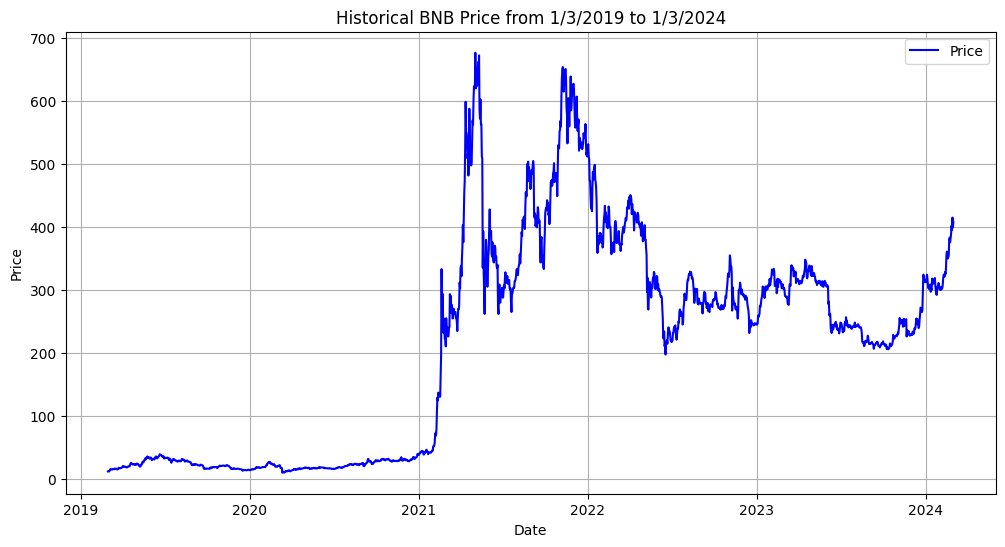

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(bnb_df['Date'], bnb_df['Price'], label='Price', color='b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical BNB Price from 1/3/2019 to 1/3/2024')
plt.legend()
plt.grid(True)
plt.show()


##### Boxplot for Price

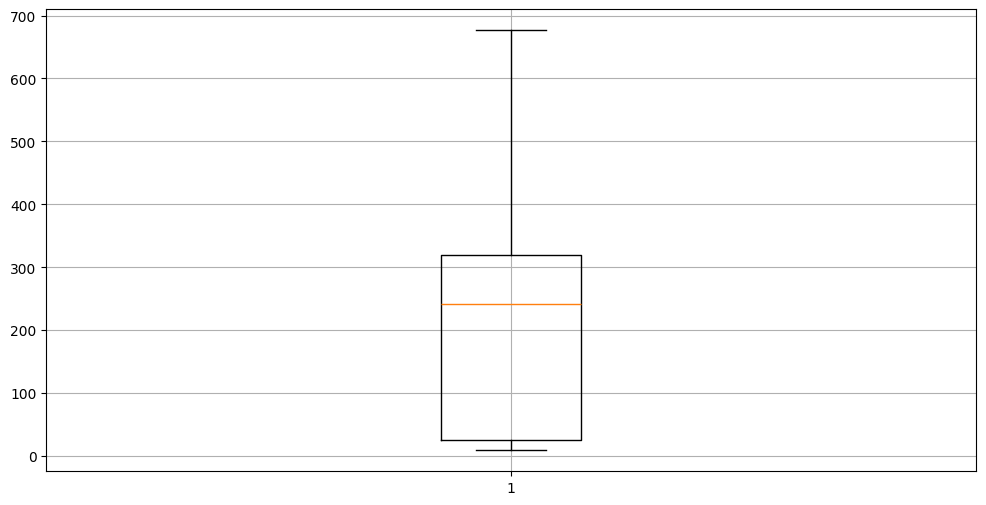

In [28]:
plt.figure(figsize=(12, 6))
plt.boxplot(bnb_df['Price'])
plt.grid()
plt.show()

### Model Training

##### Linear Regression

In [29]:
# Define features
features = ['Open', 'High', 'Low', 'Vol.', 'Change %']

# Define the target variable
target = 'Price'

In [30]:
# Split the data into training and testing sets
X = bnb_df[features]
y = bnb_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training data count: {X_train.shape[0]}")
print(f"Testing data count: {X_test.shape[0]}")

Training data count: 1462
Testing data count: 366


In [31]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 9.292147418769089
R^2 Score: 0.7808297489095943
